# Predicting Population Density with Partial Differential Equations
### Jamison Moody

## The Data

The following data models a certain population where the density for each age at years 0-49 is known. Currently we are at the end of year 49 and want to predict the population density (as well as the birth rates and death rates for 30 years into the future.

Population data was given to us as an assignment in my Partial Differential Equations class with Dr. Barker at Brigham Young University. We were told to use PDEs to predict the population in future years. We were given the data shown in the graph below. After a discussion with classmates and a lot of hard work, here is the result of the project. 

In [55]:
# hide
# First we load the required modules
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import gamma
from scipy.stats import beta
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

# Load matlab file with data
pop_data = loadmat('population_density_data.mat')

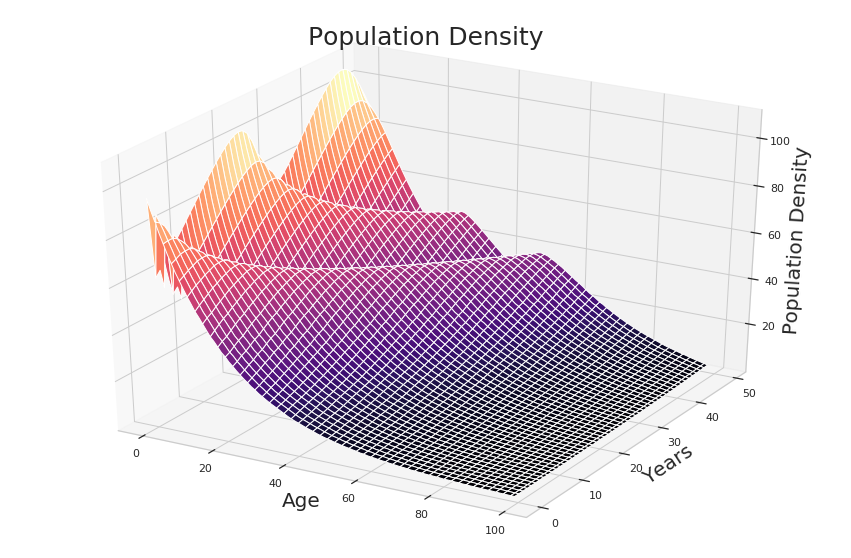

In [63]:
# hide_input
# Create a 3d plot
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

plt.title("Population Density",fontsize=25)

# Data for a three-dimensional line
X, Y = np.meshgrid(np.arange(100), np.arange(50))
Z = pop_data['M_students']

# Data for three-dimensional scattered points
ax.plot_surface(X, Y, Z, cmap='magma')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Years', fontsize=20)
ax.set_zlabel('Population Density', fontsize=20)
plt.show()

## Which PDE should we use?

Where do we start in the process of modeling this data? Since age increases at the same rate as the years pass, we will use the transport equation to model the population. We need to account for death rate, and we will have an initial condition that describes births during that given year. Putting it all together, we will have a differential equation of the form:

$u_t + cu_x = d(t, x)$

$u(t, 0) = b(t)$

Where $t$ refers to time in years, and $x$ refers to age. In this example, $d(t, x)$ is the death rate for  people of (would be) age $x$ at year $t$. Our initial condition $b(t)$ represents the number of births at year $t$.

In this application, $c = 1$.

## Modeling Birth Rate

To model birth rate, we will fit parameters of a function of the form:

$u(t,0) = \sum_{i=0}^{99} c_1\cdot\gamma(i)\cdot u(t-1,i)$

Here $\gamma$ refers to the Gamma distribution with parameters $a$ and $\theta$ (scale). The intiution behind this function is that for a given year, the number of births will depend on the portion of the population that could give birth in the previous year. 

We sum up the portion of each age group that can give birth multiplied by the size of that age group from the prior year.

In [57]:
# collapse-show
# We will now do a curve fit
import scipy.integrate as integrate
from scipy.optimize import curve_fit


def birth_func(t, a, scale, c_1):
    """
    Function we will fit to solve for births
    """
    x = np.arange(0,100)
    g = c_1*gamma(a=a, scale=scale).pdf(x)
    
    z = Z[t.astype(np.int32),:]
    
    return np.sum(g*z, axis=1)



# After some changing of the bounds, we have something that converges nicely
popt, pcov = curve_fit(birth_func, np.arange(49), Z[1:,0], bounds=([3,0,2], [np.inf, 2, np.inf]))

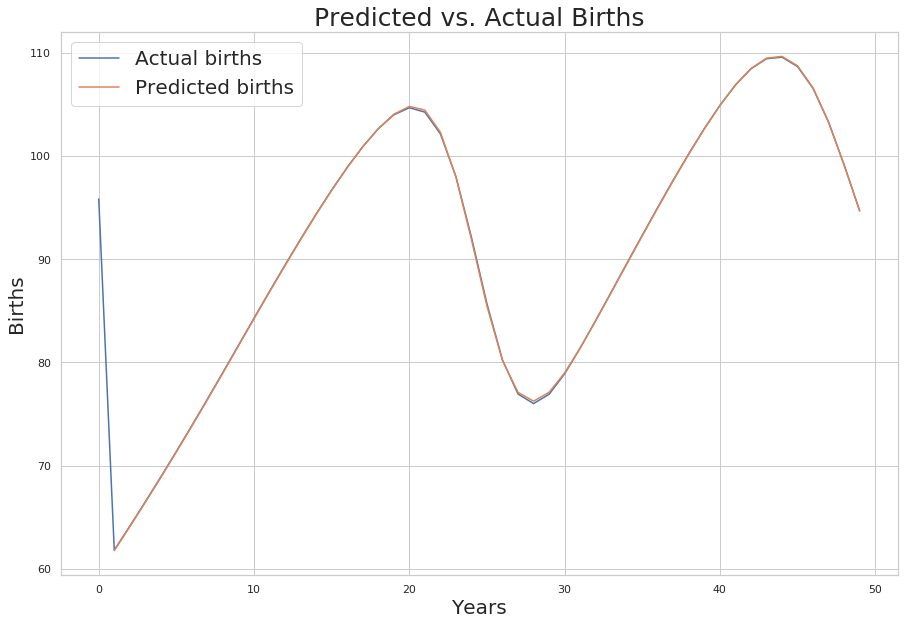

In [62]:
# hide_input
%matplotlib inline

# Plot our actual birth rate compared to our predicted birth rate
plt.figure(figsize=(15,10))
plt.title("Predicted vs. Actual Births", fontsize=25)
plt.plot(np.arange(50), Z[:,0], label = "Actual births")
plt.plot(np.arange(1,50), birth_func(np.arange(49),popt[0],popt[1],popt[2]), label="Predicted births")
plt.xlabel("Years", fontsize=20)
plt.ylabel("Births", fontsize=20)
plt.legend(fontsize=20)
plt.show()

We now have the birth rate for a given age group as represented by $c_1\cdot Gamma(a, \theta)$ where $c_1 = 2.064$, $a = 116.37$, and $\theta = 0.2$.

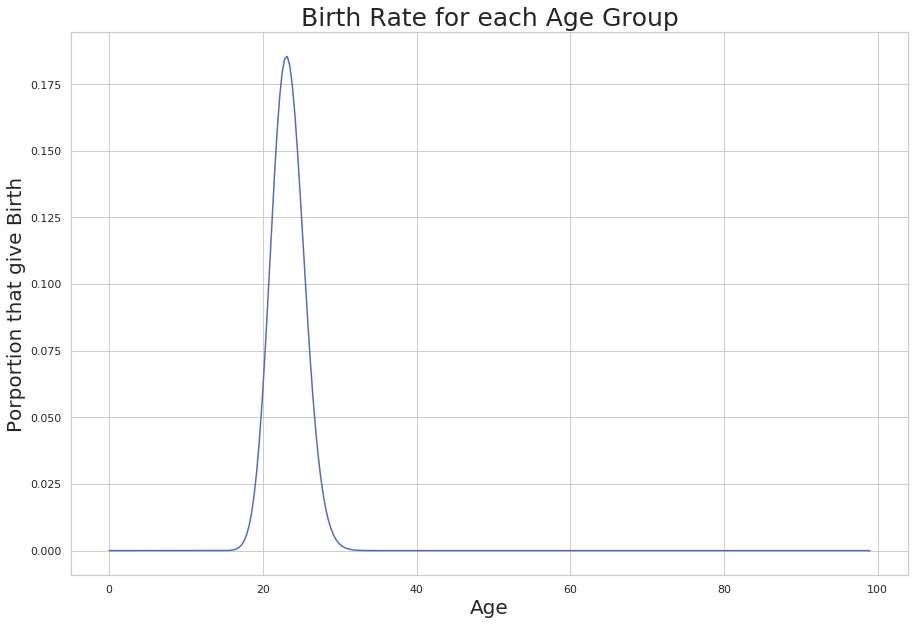

In [65]:
# hide input
plt.figure(figsize=(15,10))
plt.title("Birth Rate for each Age Group", fontsize=25)
x = np.linspace(0,99,300)
plt.plot(x, gamma(a=116.37, scale=.2).pdf(x))
plt.xlabel("Age", fontsize=20)
plt.ylabel("Porportion that give Birth", fontsize=20)
plt.show()

## Modeling Death Rate

In order to model death rate, we will need to predict those that die from each age group each year. This can be determined by:

$D(t, x) = u(t, x) - u(t-1, x-1)$

In other words, for a given age group $x$, we want to know how many didn't make it to the next year. We can fit a function of the form:

$d(t, x) = c_1\cdot \beta(x-1)\cdot u(t-1, x-1) + c_2$

Where $\beta$ refers to the Beta distribution with parameters $a$ and $b$. The Beta distbution is built to model the portion that are died by year $t$.

In [77]:
# collapse_show
# Get the deaths for each age group over all time
deaths = Z[1:,1:] - Z[:-1,:-1]

# Create a function to model death using the beta distribution
def death_func(t, a, b, c_1, c_2, e):
    z = Z[int(t),:-1]
    x = np.arange(99)/103 +.03
    g = c_1*beta(a=a, b=b).pdf(x) + c_2
    return g*np.squeeze(z)

# Fit the function after adjusting the bounds
# Here we fit on deaths at year 1 (the 0-th element of the deaths array)
# We assume our death function does not change as a function of t
popt2, pcov2 = curve_fit(death_func, [0], deaths[0], bounds=([0,0,-np.inf,-np.inf,-np.inf], [.5, .5, np.inf, np.inf, np.inf]))

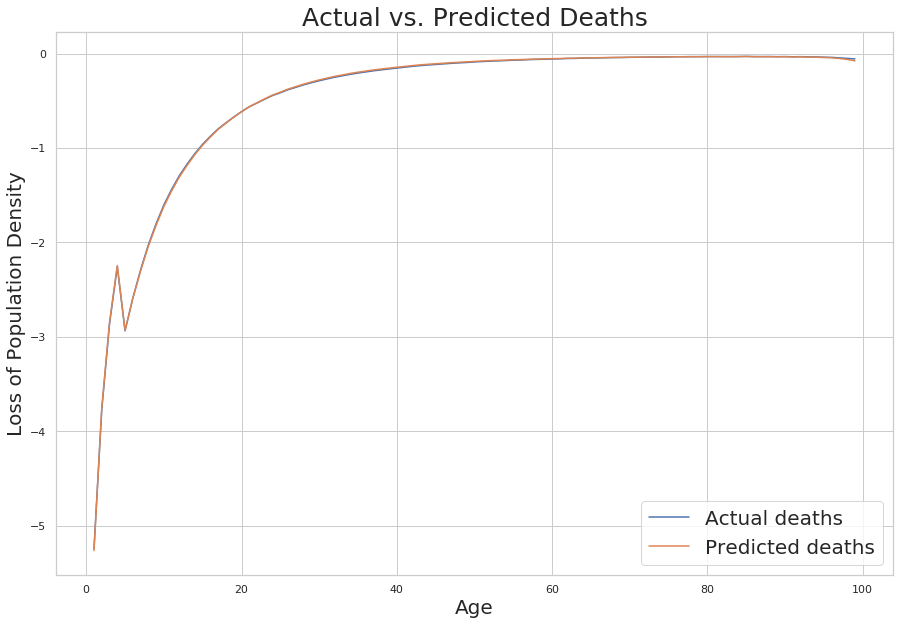

In [78]:
# hide_input
# Plot the number of deaths across year 5 (a different year than we fit to) to show our function works
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,100), deaths[4], label="Actual deaths")
plt.plot(np.arange(1,100), death_func(4,popt2[0],popt2[1],popt2[2],popt2[3],popt2[4]), label="Predicted deaths")
plt.legend(fontsize=20)
plt.title("Actual vs. Predicted Deaths", fontsize=25)
plt.ylabel("Loss of Population Density", fontsize=20)
plt.xlabel("Age", fontsize=20)
plt.show()

We now have the death rate for a given age group as represented by $c_1\cdot Beta(a, b) + c_2$, where $c_1 = -.0424$, $a = .2717$, $b = .2889$ and $c_2 = 0.0092$. We also have the input $x$ transformed by $\frac{x}{103} + .03$.

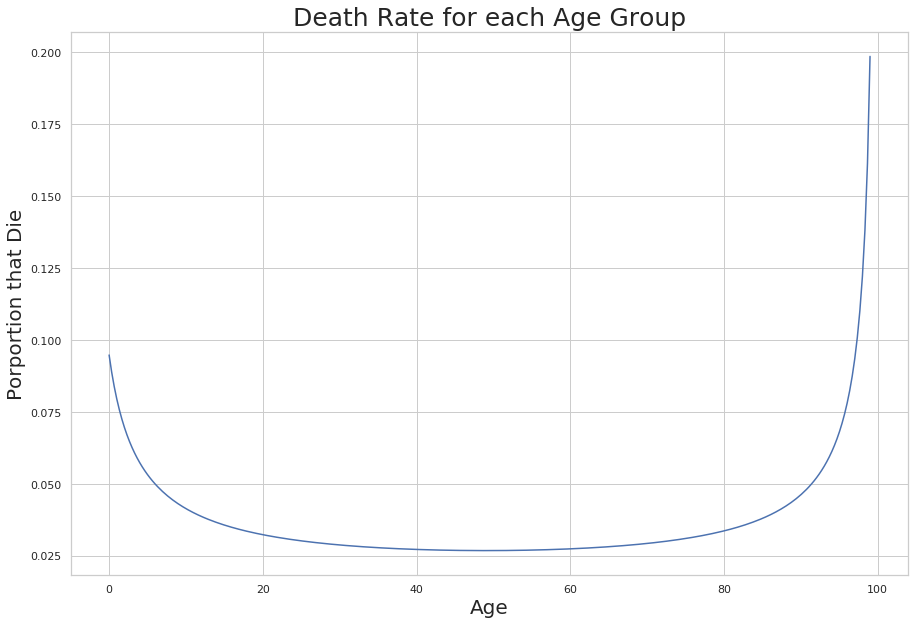

In [79]:
# hide_input
plt.figure(figsize=(15,10))
plt.title("Death Rate for each Age Group", fontsize=25)
x = np.linspace(0,99,300)
plt.plot(x, -popt2[2]*beta(a=popt2[0], b=popt2[1]).pdf(x/103+.03) + popt2[3])
plt.ylabel("Porportion that Die", fontsize=20)
plt.xlabel("Age", fontsize=20)
plt.show()

## Setting up a Finite Difference Scheme

In order to predict the population growth for the next 30 years, we need to set up a finite difference scheme and then iterate over each year. 

Denote $u(t_n, x_j)$ as $u_j^{n}$ and using forward first-order differences, we have:

$u_x = \frac{u_{j+1}^{n} - u_{j}^{n}}{h} = u_{j+1}^{n} - u_{j}^{n}$ 

since $h = 1$ and 

$u_t = \frac{u_{j+1}^{n+1} - u_{j+1}^{n}}{h} = u_{j+1}^{n+1} - u_{j+1}^{n}$.

Thus, our finite difference scheme is represented as:

$u_{j+1}^{n+1} - u_{j+1}^{n} + u_{j+1}^{n} - u_{j}^{n} = u_{j+1}^{n+1} - u_{j}^{n} = d(t,x)$

Where $d(t,x)$ is the death function defined above. We can rewrite this as:

$u_{j+1}^{n+1} = u_{j}^{n} + d(t_n,x_j)$

With boundary condition:

$u_{0}^{n+1} = b(t_n)$ 

Where $b(t)$ was defined previously as the birth function. We can also model the intial distribution as a decaying exponential function (using a curve fit), but this is not necessary to use it because we already have the initial age data. Nevertheless, we can use it as an initial condition if we want:

$u_{j}^{0} = \frac{7}{6}e^{-.05(j + 4)}$





## Prediction

We now iterate through the years and put our model to the test. 

In [80]:
# collapse_show
# Get our parameters as defined earlier
a1 = popt[0]
scale = popt[1]
c1 = popt[2]
a2 = popt2[0]
b = popt2[1]
c2 = popt2[2]
c3 = popt2[3]

def predict(start_year, end_year):
    
    #Create array to hold the data
    U = np.zeros((end_year - start_year,100))
    
    # Set the initial condition
    # Note the start year should something from 0 to 49
    U[0,:] = Z[start_year,:]

    for i in range(end_year - start_year - 1):
        U[i+1,0] = c1*U[i,:]@gamma(a=a1, scale=scale).pdf(np.arange(100))                      # births
        U[i+1,1:] = U[i,:-1] + (c2*beta(a=a2, b=b).pdf(np.arange(99)/103 + .03) + c3)*U[i,:-1] # rest of population
        
    return U

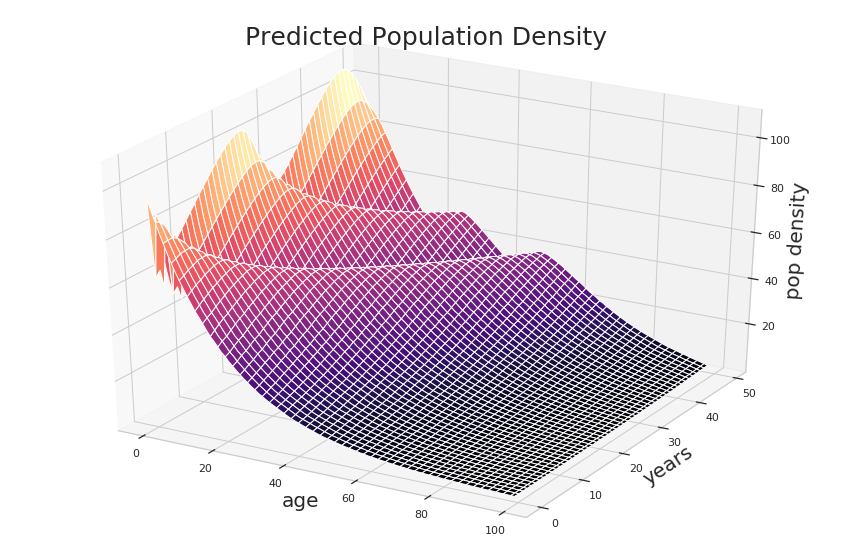

Total error in the Frobenius Norm: 11.867422480427903


In [83]:
# hide_input
# Set our start and end years
start_year = 0
end_year = 50

# Predict the original data
U = predict(start_year,end_year)

# Create a 3d plot
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

plt.title("Predicted Population Density", fontsize=25)

# Data for a three-dimensional line
X, Y = np.meshgrid(np.arange(100), np.arange(start_year, end_year))

# Data for three-dimensional scattered points
ax.plot_surface(X, Y, U, cmap='magma')
ax.set_xlabel('age',fontsize=20)
ax.set_ylabel('years',fontsize=20)
ax.set_zlabel('pop density',fontsize=20)
plt.show()

print("Total error in the Frobenius Norm:", np.linalg.norm(U-Z))

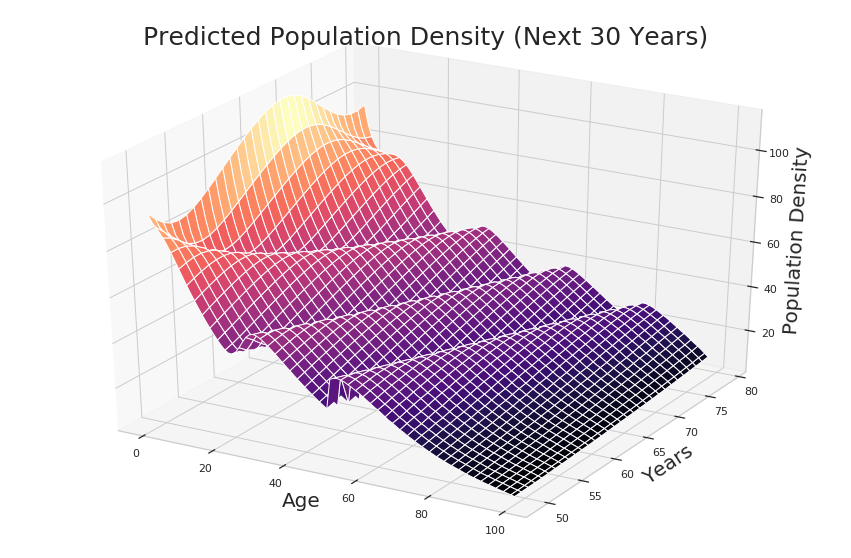

In [85]:
# hide_input
# Predict the next 30 years
start_year = 49
end_year = 80

# Predict the next 30 years
U = predict(start_year,end_year)

# Create a 3d plot
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

plt.title("Predicted Population Density (Next 30 Years)", fontsize=25)

# Data for a three-dimensional line
X, Y = np.meshgrid(np.arange(100), np.arange(start_year, end_year))

# Data for three-dimensional scattered points
ax.plot_surface(X, Y, U, cmap='magma')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Years', fontsize=20)
ax.set_zlabel('Population Density', fontsize=20)
plt.show()

# Run this cell and uncomment out this line of code to save the data
# np.save("jamison_predict.npy", U[1:,:])

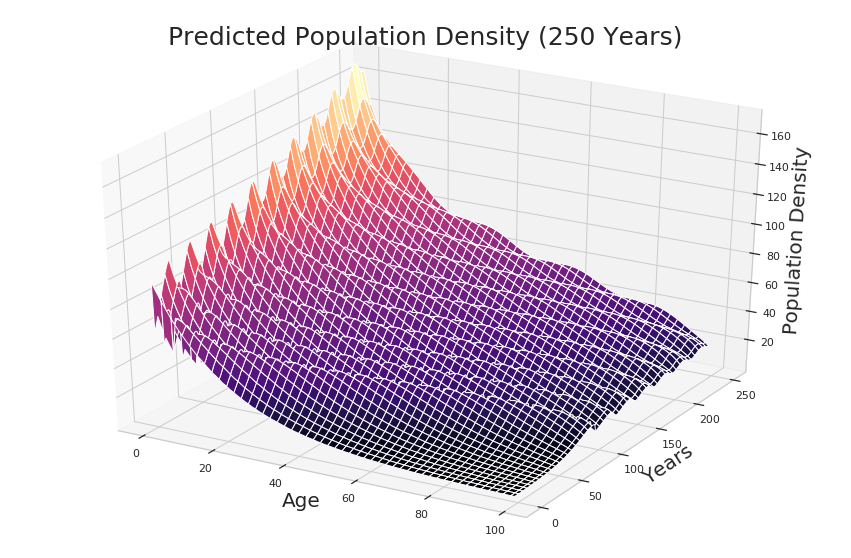

In [87]:
# hide_input
# Predict the next 250 years!
start_year = 0
end_year = 250

U = predict(start_year,end_year)

# Create a 3d plot
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

plt.title("Predicted Population Density (250 Years)",fontsize=25)

# Data for a three-dimensional line
X, Y = np.meshgrid(np.arange(100), np.arange(start_year, end_year))

# Data for three-dimensional scattered points
ax.plot_surface(X, Y, U, cmap='magma')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Years', fontsize=20)
ax.set_zlabel('Population Density', fontsize=20)
plt.show()

In [88]:
# hide
import numpy as np
prediction = np.load("jamison_predict.npy")



# This array contains the predicted number of K-12 students for the next 30 years, starting with kindergarten. The array should be 30 by 13 in size.
def part1():
    U = predict(49,80)
    
    # create array for ___
    array_1 = U[1:,:]

    # make sure array is correct shape
    assert array_1.shape[0] == 30
    assert array_1.shape[1] == 100

    return array_1

# This array contains the birth rate for each age group. The array should be 1 by 100, starting with age 1.
def part2():
    br = gamma(a=116.37, scale=.2).pdf(np.arange(100)).reshape(1,-1)
    # create array for ___
    array_2 = br

    # make sure array is correct shape
    assert array_2.shape[0] == 1
    assert array_2.shape[1] == 100

    return array_2

# This array contains the death rate for each age group. The array should be 1 by 100, starting with age 1.
def part3():
    dr = np.zeros(100)
    x = np.arange(99)
    dr[:-1] = -popt2[2]*beta(a=popt2[0], b=popt2[1]).pdf(x/103+.03) + popt2[3]
    dr[-1] = 1 # Dr. Barker said we could assume the death rate of 100 year olds (99th index) is 100%
    # create array for ___
    array_3 = dr.reshape(1,-1)

    # make sure array is correct shape
    assert array_3.shape[0] == 1
    assert array_3.shape[1] == 100

    return array_3

FileNotFoundError: [Errno 2] No such file or directory: 'jamison_predict.npy'